In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

In [2]:
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [3]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *

In [4]:
#配置路径
data_dir = './processed_data'
vocab_file_age = './processed_data/Age.txt'
vocab_file_gender = './processed_data/Gender.txt'
vocab_file_education = './processed_data/Education.txt'
vocab_size = 40000

In [5]:
#神经网络配置
max_features = 40001
maxlen = 400
batch_size = 128
embedding_dims = 50
epochs = 8

In [6]:
import pandas as pd
file_proce_path = './Data/train_2.csv'

train_2 = pd.read_csv(file_proce_path,encoding='utf-8')
train_2['Query_List'] = train_2['Query_List'].apply(lambda x:x.split(' '))

train_2.head()

,Unnamed: 0,ID,Age,Gender,Education,Query_List
0,0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,"[柔和, 双沟, 女生, 中财网, 首页, 财经, 周公, 解梦, 大全, 查询, 2345..."
1,1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"[广州, 厨宝, 烤箱, 世情, 人情, 雨送, 黄昏, 花易落, 风干, 泪痕, 厦门, ..."
2,2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,"[钻石, 之泪, 耳机, 盘锦, 沈阳, 旅顺, 公交, 辽宁, 阜新, 车牌, baidu..."
3,3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,"[受欢迎, 狗狗, 排行榜, 场景, 范例, 三维, 绘图, 软件, 酸奶, 壮观, 衣服,..."
4,4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,"[干槽症, 自愈, 太太, 万岁, 舒心, 美国, 干槽症, 眼皮, 怎么回事, 麦当劳, ..."


In [7]:
age_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}
gender_to_id = {1:0,2:1}
education_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}

In [8]:
Age_label = train_2[['Age','Query_List']]
Age_label = Age_label[~(Age_label['Age'] == 0)]

X_age = Age_label['Query_List'].values.tolist()
Y_age = Age_label['Age'].values.tolist()

In [9]:
age_words, age_word_to_id = read_vocab(vocab_file_age)

In [10]:
#全部数据
data = list(zip(X_age,Y_age))
del X_age,Y_age
X_age,Y_age = zip(*data)

In [11]:
#乱序
random.shuffle(data)

In [12]:
#切分训练集和测试集
x_train_data,x_test_data,y_train_data,y_test_data = train_test_split(X_age,Y_age,random_state =1)

In [13]:
#对文本的词ID和类别ID编码
x_train = encode_sentences([content for content in x_train_data], age_word_to_id)
y_train = to_categorical(encode_cate(y_train_data, age_to_id))
x_test = encode_sentences([content for content in x_test_data], age_word_to_id)
y_test = to_categorical(encode_cate(y_test_data, age_to_id))

In [14]:
print("对序列做padding,保证是samples*timestep的维度")
x_train = sequence.pad_sequences(x_train,maxlen = maxlen)
x_test = sequence.pad_sequences(x_test,maxlen = maxlen)
print('x_train shape:',x_train.shape)
print("x_test shape:",x_test.shape)
print('y_test shape:', y_test.shape)

对序列做padding,保证是samples*timestep的维度
x_train shape: (73750, 400)
x_test shape: (24584, 400)
y_test shape: (24584, 6)


In [15]:
print('构建模型....')
model = TextCNN(maxlen,max_features,embedding_dims,class_num = 6).get_model()
model.compile('adam','categorical_crossentropy',metrics = ['accuracy'])

构建模型....


In [16]:
print('训练....')
#设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5',verbose = 1),
    EarlyStopping(monitor = 'val_accuracy',patience = 2,mode = 'max')
]

训练....


In [17]:
#fit拟合数据
history = model.fit(x_train,y_train,
          batch_size = batch_size,
          epochs = epochs,
          callbacks = my_callbacks,
          validation_data=(x_test, y_test))

Epoch 1/8
577/577 [==============================] - ETA: 0s - loss: 1.1668 - accuracy: 0.5328
Epoch 00001: saving model to .\cnn_model.h5
577/577 [==============================] - 41s 71ms/step - loss: 1.1668 - accuracy: 0.5328 - val_loss: 1.0915 - val_accuracy: 0.5734
Epoch 2/8
576/577 [============================>.] - ETA: 0s - loss: 0.9770 - accuracy: 0.6301
Epoch 00002: saving model to .\cnn_model.h5
577/577 [==============================] - 40s 69ms/step - loss: 0.9770 - accuracy: 0.6301 - val_loss: 1.0811 - val_accuracy: 0.5769
Epoch 3/8
576/577 [============================>.] - ETA: 0s - loss: 0.7853 - accuracy: 0.7222
Epoch 00003: saving model to .\cnn_model.h5
577/577 [==============================] - 40s 69ms/step - loss: 0.7853 - accuracy: 0.7223 - val_loss: 1.1448 - val_accuracy: 0.5684
Epoch 4/8
576/577 [============================>.] - ETA: 0s - loss: 0.5213 - accuracy: 0.8383
Epoch 00004: saving model to .\cnn_model.h5
577/577 [==============================] - 40

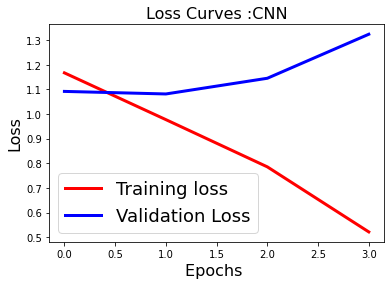

In [18]:
#训练中信息输出
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

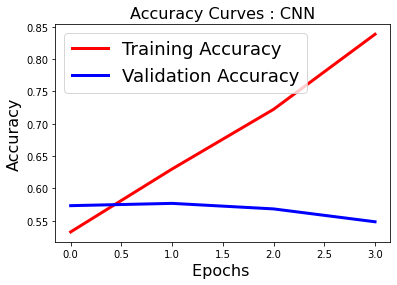

In [19]:
fig2 = plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
plt.show()